## To compare different results 

In [33]:
from ast import literal_eval
from os import listdir
from os.path import isfile, join
from scipy.sparse import csr_matrix, load_npz, save_npz
from tqdm import tqdm
import statistics as stats
import seaborn as sns
import datetime
import json
import numpy as np
import pandas as pd
import time
import yaml
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import operator
from utils.io import get_yelp_df, df_to_sparse, filter_yelp_df, date_to_timestamp, get_corpus_idx_list, valid_combinations, setBinary
from utils.matrix import get_I_C, get_rating_timestamp_matrix, get_UC_Matrix, getImplicitMatrix
from utils.timesplit import time_ordered_splitModified
from prediction.models import preprocess, individualKNNPrediction, simpleKNNPrediction,train, prediction
from evaluation.metrics import evaluate

## Dataset files 

In [2]:
#reviewJson = "..\\data\\Export_CleanedReview.json"
reviewJsonWithClosedRes = "..\\data\\Export_CleanedReviewWithClosedRes.json"
reviewJsonWithBusAvgStars = "..\\data\\Export_CleanedReviewNew_1011.json"
# with open(reviewJson, encoding = 'utf-8') as json_file:
#     data = json_file.readlines()
#     data = list(map(json.loads, data))

#This appeared to be a neasted list, just use data[0] to read
# df_review = pd.DataFrame(data[0])

## Load Data
Select top frenquent user and top frequenty restaurants that had at least 1 review >= 4 stars (Kickking out users that gave all  reviews <=3 and restaurants that never got start >= 4 stars)

## Get rating-UI and timestamp-UI matrix from original df

#### Get Explicit UC Matrix

## Time ordered split 

## Time Order Split modified for adjusting training dataset size

In [3]:
# "Modified this to take in train sampling"
# "Modified this to add and return original valid set"

# def time_ordered_splitModified(rating_matrix, ratingWuserAvg_matrix, timestamp_matrix, ratio=[0.5, 0.2, 0.3],
#                        implicit=True, remove_empty=False, threshold=3,
#                        sampling=False, sampling_ratio=0.1, trainSampling=1):
#     """
#     Split the data to train,valid,test by time
#     ratio:  train:valid:test
#     threshold: for implicit representation
#     """
#     if implicit:
#         temp_rating_matrix = sparse.csr_matrix(rating_matrix.shape)
#         temp_rating_matrix[(rating_matrix > threshold).nonzero()] = 1
#         rating_matrix = temp_rating_matrix
#         timestamp_matrix = timestamp_matrix.multiply(rating_matrix)
#         #ratingWuserAvg_matrix = ratingWuserAvg_matrix.multiply(rating_matrix)

#     nonzero_index = None

#     #Default false, not removing empty columns and rows
#     #Should not have this case, since users should have at least 1 record of 4,5 
#     #And restuarant should have at least 1 record of 4,5 
#     if remove_empty:
#         # Remove empty columns. record original item index
#         nonzero_index = np.unique(rating_matrix.nonzero()[1])
#         rating_matrix = rating_matrix[:, nonzero_index]
#         timestamp_matrix = timestamp_matrix[:, nonzero_index]
#         ratingWuserAvg_matrix = ratingWuserAvg_matrix[:, nonzero_index]

#         # Remove empty rows. record original user index
#         nonzero_rows = np.unique(rating_matrix.nonzero()[0])
#         rating_matrix = rating_matrix[nonzero_rows]
#         timestamp_matrix = timestamp_matrix[nonzero_rows]
#         ratingWuserAvg_matrix = ratingWuserAvg_matrix[nonzero_rows]

#     user_num, item_num = rating_matrix.shape

#     rtrain = []
#     rtrain_userAvg = []
#     rtime = []
#     rvalid = []
#     rvalid_userAvg = []
#     rtest = []
#     rtest_userAvg = []
#     # Get the index list corresponding to item for train,valid,test
#     item_idx_train = []
#     item_idx_valid = []
#     item_idx_test = []
    
#     for i in tqdm(range(user_num)):
#         #Get the non_zero indexs, restuarants where the user visited/liked if implicit 
#         item_indexes = rating_matrix[i].nonzero()[1]        
#         #Get the data for the user
#         data = rating_matrix[i].data      
#         #Get time stamp value 
#         timestamp = timestamp_matrix[i].data 
#         #Get review stars with user avg data 
#         if implicit == False:
#             dataWuserAvg = ratingWuserAvg_matrix[i].data
#         #Non zero reviews for this user
#         num_nonzeros = len(item_indexes)
        
#         #If the user has at least one review
#         if num_nonzeros >= 1:
#             num_test = int(num_nonzeros * ratio[2])
#             num_valid = int(num_nonzeros * (ratio[1] + ratio[2]))
#             valid_offset = num_nonzeros - num_valid
            
#             # Adding this for sampling for training set
#             valid_offsetSample = int(valid_offset*trainSampling)
#             test_offset = num_nonzeros - num_test

#             #Sort the timestamp for each review for the user
#             argsort = np.argsort(timestamp)
            
#             #Sort the reviews for the user according to the time stamp 
#             data = data[argsort]
            
#             #Sort the review with user avg accoridng to the time stamp
#             if implicit == False:
#                 dataWuserAvg = dataWuserAvg[argsort]
            
#             #Non-zero review index sort according to time
#             item_indexes = item_indexes[argsort]
            
#             #list of ratings, num of valid_offset index, index where there's non-zeros
#             #if take from old to new
#             #rtrain.append([data[:valid_offsetSample], np.full(valid_offsetSample, i), item_indexes[:valid_offsetSample]])
#             #if take from new to old
#             rtrain.append([data[valid_offset-valid_offsetSample:valid_offset], np.full(valid_offsetSample, i), item_indexes[valid_offset-valid_offsetSample:valid_offset]])
#             rvalid.append([data[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
#                            item_indexes[valid_offset:test_offset]])
#             rtest.append([data[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])
            
#             if implicit == False:
#                 #Now for the rating matrix that considers user average rating
#                 #list of ratings, num of valid_offset index, index where there's non-zeros
#                 #from old to new
#                 #rtrain_userAvg.append([dataWuserAvg[:valid_offsetSample], np.full(valid_offsetSample, i), item_indexes[:valid_offsetSample]])
#                 #take nearest
#                 rtrain_userAvg.append([dataWuserAvg[valid_offset-valid_offsetSample:valid_offset], np.full(valid_offsetSample, i), item_indexes[valid_offset-valid_offsetSample:valid_offset]])                
                    
#                 rvalid_userAvg.append([dataWuserAvg[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
#                                item_indexes[valid_offset:test_offset]])
                
#                 rtest_userAvg.append([dataWuserAvg[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])
                
#             item_idx_train.append(item_indexes[:valid_offsetSample])
            
#         else:
#             item_idx_train.append([])
    
#     rtrain = np.array(rtrain)
#     rvalid = np.array(rvalid)
#     rtest = np.array(rtest)
   
#     if implicit == False:
#         rtrain_userAvg = np.array(rtrain_userAvg)
#         rvalid_userAvg = np.array(rvalid_userAvg)
#         rtest_userAvg = np.array(rtest_userAvg)

#     #take non-zeros values, row index, and column (non-zero) index and store into sparse matrix
#     rtrain = sparse.csr_matrix((np.hstack(rtrain[:, 0]), (np.hstack(rtrain[:, 1]), np.hstack(rtrain[:, 2]))),
#                                shape=rating_matrix.shape, dtype=np.float32)
#     rvalid = sparse.csr_matrix((np.hstack(rvalid[:, 0]), (np.hstack(rvalid[:, 1]), np.hstack(rvalid[:, 2]))),
#                                shape=rating_matrix.shape, dtype=np.float32)
#     rtest = sparse.csr_matrix((np.hstack(rtest[:, 0]), (np.hstack(rtest[:, 1]), np.hstack(rtest[:, 2]))),
#                               shape=rating_matrix.shape, dtype=np.float32)
    
#     if implicit == False:
#         rtrain_userAvg = sparse.csr_matrix((np.hstack(rtrain_userAvg[:, 0]), (np.hstack(rtrain_userAvg[:, 1]), np.hstack(rtrain_userAvg[:, 2]))),
#                                    shape=rating_matrix.shape, dtype=np.float32)
#         rvalid_userAvg = sparse.csr_matrix((np.hstack(rvalid_userAvg[:, 0]), (np.hstack(rvalid_userAvg[:, 1]), np.hstack(rvalid_userAvg[:, 2]))),
#                                    shape=rating_matrix.shape, dtype=np.float32)
#         rtest_userAvg = sparse.csr_matrix((np.hstack(rtest_userAvg[:, 0]), (np.hstack(rtest_userAvg[:, 1]), np.hstack(rtest_userAvg[:, 2]))),
#                                   shape=rating_matrix.shape, dtype=np.float32)

#     return rtrain, rvalid, rtest,rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, timestamp_matrix, item_idx_train, item_idx_valid, item_idx_test

## All Model

In [3]:
#Get a UI matrix if it's not item_similarity based or else IU
def predictUU(matrix_train, k, chooseWeigthMethod, similarity1=None, similarity2=None, similarity3=None, similarity4=None, similarity5=None, item_similarity_en = False):
    prediction_scores = []
    #Convert from list to ndarray, add an axis
    if isinstance(chooseWeigthMethod, list):
        chooseWeigthMethod = np.array(chooseWeigthMethod)[:, np.newaxis]
   
    "make sure that when passing in chooseWeightMethod, the weight must be aligned with similarity metrices, even if set to None"
    "They should add to 1 as well"
    #inverse to IU matrix
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    #for each user or item, depends UI or IU 
    for user_index in tqdm(range(matrix_train.shape[0])):
    #for user_index in tqdm(range(10,20)):
        
        numberSimilarMatrix = 0
        # Get user u's prediction scores for all items 
        #Get prediction/similarity score for each user 1*num or user or num of items
        if similarity1 is not None:
            vector_u1 = similarity1[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u1 = [0]*matrix_train.shape[0]
            
        if similarity2 is not None:
            vector_u2 = similarity2[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u2 = [0]*len(vector_u1)
            
        if similarity3 is not None:
            vector_u3 = similarity3[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u3 = [0]*len(vector_u1)
            
        if similarity4 is not None:
            vector_u4 = similarity4[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u4 = [0]*len(vector_u1)
        
        if similarity5 is not None:
            vector_u5 = similarity5[user_index]
            numberSimilarMatrix += 1
        else:
            vector_u5 = [0]*len(vector_u1)
        
        #Temperary vector that stacks all 4 vectors together
        tempVector = np.array([vector_u1,vector_u2,vector_u3,vector_u4, vector_u5])
        
        if chooseWeigthMethod is None:
            #Get the similarity score from the first similarity matrix anyways 
            vector_u = vector_u1.copy()
            
        #If we are choosing the max, min, avg or similarity scores
        if chooseWeigthMethod is not None:
            if chooseWeigthMethod == 'max':
                vector_u = tempVector.max(axis=0)
            elif chooseWeigthMethod == 'min':
                vector_u = tempVector.min(axis=0)
            elif chooseWeigthMethod == 'average':
                vector_u = tempVector.mean(axis=0)
            elif isinstance(chooseWeigthMethod, np.ndarray):
                #Validate that number of weights passed in equals number of matrices
                #assert(len(chooseWeigthMethod) == numberSimilarMatrix)
                #Get the new combined similarity vector 
                weighted_u = tempVector * chooseWeigthMethod
                vector_u =np.sum(weighted_u, axis=0)
                #print((vector_u == vector_u4).sum())
                
        similar_users = vector_u.argsort()[::-1][1:k+1]
        
        # Get neighbors similarity weights and ratings
        #similar_users_weights = similarity1[user_index][similar_users]
        similar_users_weights = vector_u[similar_users]
        
        #similar_users_weights_sum = np.sum(similar_users_weights)
        #print(similar_users_weights.shape)
        #shape: num of res * k
        similar_users_ratings = matrix_train[similar_users].toarray()
              
        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
        #print(prediction_scores_u)
        
        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
        
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    return res
    #return vector_u

## Evaluation

### TuneK method

In [4]:
def individualKNNPrediction (similarityMatrix, predictionMatrix, kRange, validOrTestMatrix):
    "Declaration for kRange = range(50,120,10)"
    similarity = train(similarityMatrix)
    MAP10 = {}
    for kValue in kRange:
        user_item_prediction_score = predict(predictionMatrix, kValue, similarity, item_similarity_en= False)
        user_item_predict = prediction(user_item_prediction_score, 50, predictionMatrix)
        user_item_res = evaluate(user_item_predict, validOrTestMatrix)
        
        
        MAP10[kValue] = user_item_res.get('MAP@10')[0]
        
    return MAP10


def simpleKNNPrediction (similarityMatrix, predictionMatrix, kValue, validOrTestMatrix):
    "Declaration for kRange = range(50,120,10)"
    similarity = train(similarityMatrix)
    user_item_prediction_score = predict(predictionMatrix, kValue, similarity, item_similarity_en= False)
    user_item_predict = prediction(user_item_prediction_score, 50, predictionMatrix)
    user_item_res = evaluate(user_item_predict, validOrTestMatrix)

    MAP10= user_item_res.get('MAP@10')[0]
        
    return MAP10

In [4]:
#Pass in k range, return a dictionary for MAP@10
def individualKNNPredictionMaxMinAvg (similarityOne, similarityTwo, similarityThree, similarityFour, similarityFive, predictionMatrix, kRange, validOrTestMatrix, method):
    "Declaration for kRange = range(50,120,10)"
    #similarity = train(similarityMatrix)
    MAP10 = {}
    for kValue in kRange:
        user_item_prediction_score = predictUU(predictionMatrix, kValue, method, similarityOne, 
                                               similarityTwo, similarityThree, similarityFour,similarityFive)
        user_item_predict = prediction(user_item_prediction_score, 50, predictionMatrix)
        user_item_res = evaluate(user_item_predict, validOrTestMatrix) 
        MAP10[kValue] = user_item_res.get('MAP@10')[0]
        
    return MAP10

In [5]:
#Pass in k range, return a dictionary for MAP@10
def SingleKNNPredictionMaxMinAvg (similarityOne, similarityTwo, similarityThree, similarityFour, similarityFive, predictionMatrix, kValue, validOrTestMatrix, method):
    "Taking in a single k value"
    #similarity = train(similarityMatrix)

    user_item_prediction_score = predictUU(predictionMatrix, kValue, method, similarityOne, 
                                           similarityTwo, similarityThree, similarityFour,similarityFive)
    user_item_predict = prediction(user_item_prediction_score, 50, predictionMatrix)
    user_item_res = evaluate(user_item_predict, validOrTestMatrix) 
    MAP10 = user_item_res.get('MAP@10')[0]
        
    return MAP10

In [6]:
# def setBinary (Explicitmatrix, threshold):
#     temp_rating_matrix = sparse.csr_matrix(Explicitmatrix.shape)
#     temp_rating_matrix[(Explicitmatrix >= threshold).nonzero()] = 1
#     Explicitmatrix = temp_rating_matrix
#     return Explicitmatrix

## Get different combinations for the weighting combination

In [11]:
# from itertools import permutations
# def valid_combinations(weights, numCandidate):
#     '''generator of possible combinations of weights elements that add up to 1'''
#     list_length = len(weights) # we will need this
#     list_uniqueComb = []
#     #out of the possible weights, find numCandidate numbers for combination
#     for possible in permutations(weights,numCandidate): # all possible orderings of weights
        
#         #If combination found to sum up to 1 and unique
#         if sum(possible) == 1 and possible not in list_uniqueComb:
#             list_uniqueComb.append(possible)
            
#     return list_uniqueComb

### Get the weigthing combinations

In [6]:
numCandidate = 5
original = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1] * 4
listCom = list(valid_combinations(original,numCandidate))
len(listCom)

859

## 1.K-fold cross validation 2nd Level - Individual Performance

In [9]:
# 2013 - 2018
cross_dict = {}
for year in range(2013,2018):
    temp = {}
#     df = utils.Io.get_yelp_df(path ='', filename=reviewJsonWithBusAvgStars, sampling= True, cross_valid = True, start_date = '2012-01-01', end_date = '2013-06-01')
    df = get_yelp_df(path ='', filename=reviewJsonWithBusAvgStars, sampling= True, cross_valid = True, start_date = str(2011) + '-01-01', end_date = str(2011+1) + '-06-01')

    df['reviewStars_userAvg'] = df['review_stars'] - df['user_avg_stars']
    df.loc[df['reviewStars_userAvg'] == 0, "reviewStars_userAvg"] = 0.01
    df['reviewStars_busAvg'] = df['review_stars'] - df['business_stars']
    df.loc[df['reviewStars_busAvg'] == 0, "reviewStars_busAvg"] = 0.01

    rating_matrix, ratingWuserAvg_matrix, timestamp_matrix, IC_Matrix = get_rating_timestamp_matrix(df)

    rtrain, rvalid, rtest, rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, rtime, item_idx_matrix_train,item_idx_matrix_valid, item_idx_matrix_test = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=False)  
    rtrain_implicit, rvalid_implicit, rtest_implicit, rtrain_userAvg_implicit, rvalid_userAvg_implicit, rtest_userAvg_implicit, nonzero_index, rtime, item_idx_matrix_train_implicit,item_idx_matrix_valid_implicit, item_idx_matrix_test_implicit = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=True)
    U_C_matrix_explicit,U_C_matrix_implicit = get_UC_Matrix(IC_Matrix,rtrain_implicit)
    userVisitMatrix = getImplicitMatrix(rtrain)
    
    kRange = range(50,130,10)
    
    #Get the MAP list for the current sampling size

    mapList1 = individualKNNPrediction(rtrain, rtrain, kRange, rvalid)
#     maximum = max(mapList1, key=mapList1.get)
#     k1 = mapList1[maximum]
    temp['explicitUI'] = mapList1
    
    mapList2 = individualKNNPrediction(rtrain_userAvg, rtrain_userAvg, kRange, rvalid)
#     maximum = max(mapList2, key=mapList2.get)
#     k2 = mapList2[maximum]
    temp['scaledExplicitUI'] = mapList2
    
    mapList3 = individualKNNPrediction(userVisitMatrix, userVisitMatrix, kRange, rvalid)
#     maximum = max(mapList3, key=mapList3.get)
#     k3 = mapList3[maximum]
    temp['UserVisitUI'] = mapList3
    
    mapList4 = individualKNNPrediction(rtrain_implicit, rtrain_implicit, kRange, rvalid)
#     maximum = max(mapList4, key=mapList4.get)
#     k4 = mapList4[maximum]
    temp['ImplicitUI'] = mapList4
    
    mapList5 = individualKNNPrediction(U_C_matrix_explicit, rtrain_implicit, kRange, rvalid)
#     maximum = max(mapList5, key=mapList5.get)
#     k5 = mapList5[maximum]
    temp['ExplicitUC'] = mapList5
    
    cross_dict[year] = temp

KeyboardInterrupt: 

cross_dict = {2013: {'combination1': {110: 0.0183,50: 0.017},
  'combination2': {100: 0.0128,50: 0.017},
  'combination3': {110: 0.0184,50: 0.017},
  'combination4': {100: 0.0141,50: 0.017},
  'combination5': {50: 0.017,60: 0.017}},
 2014: {'combination1': {110: 0.0201,50: 0.017},
  'combination2': {100: 0.0104,50: 0.017},
  'combination3': {110: 0.0208,50: 0.017},
  'combination4': {100: 0.0161,50: 0.017},
  'combination5': {50: 0.016,60: 0.017}},
 2015: {'combination1': {110: 0.0233,50: 0.017},
  'combination2': {100: 0.0127,50: 0.017},
  'combination3': {110: 0.0229,50: 0.017},
  'combination4': {100: 0.018,50: 0.017},
  'combination5': {50: 0.0177,60: 0.017}},
 2016: {'combination1': {110: 0.0215,50: 0.017},
  'combination2': {100: 0.0147,50: 0.017},
  'combination3': {110: 0.022,50: 0.017},
  'combination4': {100: 0.0168,50: 0.017},
  'combination5': {50: 0.019,60: 0.017}},
 2017: {'combination1': {110: 0.0251,50: 0.017},
  'combination2': {100: 0.0149,50: 0.017},
  'combination3': {110: 0.0251,50: 0.017},
  'combination4': {100: 0.0205,50: 0.017},
  'combination5': {50: 0.0174,60: 0.017}}}

### TuneK, find the K that yields the best performance

### Produce dictionary for k fold performance

In [173]:
#combinationName = ['explicitUI', 'scaledExplicitUI', 'UserVisitUI', 'ImplicitUI', 'ExplicitUC']
combinationName = ['combination1', 'combination2', 'combination3', 'combination4', 'combination5']
def getPerformanceSummary(combinationName, cross_dict):
    combinationTunekDict = {}
    #results = {name: [] for name in local_metric_names}
    #loop through different years 
    for yearFold in cross_dict.keys():
        tempDict = {}
        #find each combinations performance using different k 
        for combination in combinationName:
            #combine dictionary
            if combinationTunekDict.get(combination) is not None:

                result = cross_dict[yearFold][combination].copy()

                existing = combinationTunekDict[combination].copy()

                #loop through k values
                for resultKey in result.keys():
                    #if key exists add value, or else create 0 
                    combinationTunekDict[combination][resultKey].append(result[resultKey])
            else:
                #turn into list
                tempDict = cross_dict[yearFold][combination].copy()
                #print(tempDict)
                for k in tempDict.keys(): 
                    tempDict[k] = [tempDict[k]]
                combinationTunekDict[combination] = tempDict
    return combinationTunekDict


In [174]:
getPerformanceSummary(combinationName, cross_dict)

{'combination1': {110: [0.0183, 0.0201, 0.0233, 0.0215, 0.0251],
  50: [0.017, 0.017, 0.017, 0.017, 0.017]},
 'combination2': {100: [0.0128, 0.0104, 0.0127, 0.0147, 0.0149],
  50: [0.017, 0.017, 0.017, 0.017, 0.017]},
 'combination3': {110: [0.0184, 0.0208, 0.0229, 0.022, 0.0251],
  50: [0.017, 0.017, 0.017, 0.017, 0.017]},
 'combination4': {100: [0.0141, 0.0161, 0.018, 0.0168, 0.0205],
  50: [0.017, 0.017, 0.017, 0.017, 0.017]},
 'combination5': {50: [0.017, 0.016, 0.0177, 0.019, 0.0174],
  60: [0.017, 0.017, 0.017, 0.017, 0.017]}}

### Calculate average performance

In [147]:
def ComputeAvgPerformance(combinationTunekDictitonary):
    validPerformance = combinationTunekDictitonary.copy()
    for comb in validPerformance.keys():
        for kVal in validPerformance[comb].keys():
            mapList = validPerformance[comb][kVal]
            avg = round((np.average(mapList)),4)
            cI95 = round((1.96*np.std(mapList)/np.sqrt(len(mapList))),4)
            validPerformance[comb][kVal] = [avg, cI95]
    return validPerformance

In [152]:
validationPerformance = ComputeAvgPerformance(combinationTunekDict)

In [155]:
validationPerformance

{'combination1': {110: [0.0128, 0.0012], 50: [0.0102, 0.0023]},
 'combination2': {100: [0.0076, 0.0006], 50: [0.0102, 0.0023]},
 'combination3': {110: [0.0128, 0.0014], 50: [0.0102, 0.0023]},
 'combination4': {100: [0.01, 0.0007], 50: [0.0102, 0.0023]},
 'combination5': {50: [0.0103, 0.0015], 60: [0.0102, 0.0023]}}

### Now find the best K from each combination 

In [160]:
def findBestK (validationPerformance):
    comBestK = {}
    for comb in validationPerformance.keys():
        comBestK[comb] = max(validationPerformance[comb].items(), key=operator.itemgetter(1))[0]
    return comBestK

In [175]:
bestKDict = findBestK (validationPerformance)

In [176]:
bestKDict

{'combination1': 110,
 'combination2': 50,
 'combination3': 110,
 'combination4': 50,
 'combination5': 50}

## Now test 

## Validation Max, Average, Min - no cross

In [7]:
df = get_yelp_df(path ='', filename=reviewJsonWithBusAvgStars, sampling= True, cross_valid = False)

df['reviewStars_userAvg'] = df['review_stars'] - df['user_avg_stars']
df.loc[df['reviewStars_userAvg'] == 0, "reviewStars_userAvg"] = 0.01
df['reviewStars_busAvg'] = df['review_stars'] - df['business_stars']
df.loc[df['reviewStars_busAvg'] == 0, "reviewStars_busAvg"] = 0.01

In [8]:
rating_matrix, ratingWuserAvg_matrix, timestamp_matrix, IC_Matrix = get_rating_timestamp_matrix(df)

rtrain, rvalid, rtest, rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, rtime, item_idx_matrix_train,item_idx_matrix_valid, item_idx_matrix_test = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                 ratio=[0.5,0.2,0.3],
                                                                 implicit=False)  
rtrain_implicit, rvalid_implicit, rtest_implicit, rtrain_userAvg_implicit, rvalid_userAvg_implicit, rtest_userAvg_implicit, nonzero_index, rtime, item_idx_matrix_train_implicit,item_idx_matrix_valid_implicit, item_idx_matrix_test_implicit = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                 ratio=[0.5,0.2,0.3],
                                                                 implicit=True)
U_C_matrix_explicit,U_C_matrix_implicit = get_UC_Matrix(IC_Matrix,rtrain_implicit)
userVisitMatrix = getImplicitMatrix(rtrain)

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 3972.07it/s]
W:\Github\iNAGO\iNAGO_RecSys\Yelp_data_exploration\utils\timesplit.py:205: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  temp_rating_matrix[(rating_matrix > threshold).nonzero()] = 1
100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4930.99it/s]
W:\Github\iNAGO\iNAGO_RecSys\Yelp_data_exploration\utils\matrix.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  temp_matrix[(sparseMatrix > threashold).nonzero()] = 1


In [9]:
#Get the valid and test data for user visting matrix
userVisitMatrix_valid = getImplicitMatrix(rvalid)
userVisitMatrix_test = getImplicitMatrix(rtest)

In [10]:
combinationDict = {
    'comb1': [1, 2, 3, 4],
    'comb2': [1, 2, 3],
    'comb3': [1, 2, 4],
    'comb4': [2, 3, 4],
    'comb5': [1, 3, 4],
    'comb6': [1, 2],
    'comb7': [1, 3],
    'comb8': [1, 4],
    'comb9': [2, 3],
    'comb10': [2, 4],
    'combe11':[3,4]
    }

 #UU similarity, using cosine similarity
similarity1 = train(rtrain)
similarity2 = train(rtrain_userAvg)
#similarity2 = None
similarity3 =train(userVisitMatrix)
#similarity3 = None
similarity4 = train(rtrain_implicit)
similarity5 = train(U_C_matrix_explicit)

predictionMatrixDict = {'prediction1':rtrain, 
                        'prediction2': rtrain_userAvg, 
                        'prediction3:': userVisitMatrix, 
                        'prediction4': rtrain_implicit}

#Indicates whether to use similarity matrix i, or it's a none 
SimilarityMatrixIndex = {1: [similarity1, None],
                         2: [similarity2, None],
                         3: [similarity3, None],
                         4: [similarity4, None],
                         5: [similarity5, None],} 

In [12]:
#loop through the combination and make prediction using each prediction matricies
#Pass in the k ranges to loop and see performance 
def computeUUCombination(rtrain, rtrain_userAvg, userVisitMatrix, rtrain_implicit, uc_explicit, rvalid, rvalid_userAvg, rvalid_implicit, combinationDict, SimilarityMatrixIndex, kTune, method = 'max'):

#     prediction1 = {}
#     prediction2 = {}
#     prediction3 = {}
#     prediction4 = {}
    predictionComb = {}

    #loop through the combination dictionary
    for combination, indexList in combinationDict.items():
        #Loop through the similarity matrices to get similarity matricies 1-5
        #see if we enable similarity matrix i for i = 1-5
        for index in SimilarityMatrixIndex.keys():
            if index in indexList:
                if index == 1: 
                    similarityOne = SimilarityMatrixIndex[1][0]
                elif index == 2:
                    similarityTwo = SimilarityMatrixIndex[2][0]
                elif index == 3:
                    similarityThree = SimilarityMatrixIndex[3][0]
                elif index == 4:
                    similarityFour = SimilarityMatrixIndex[4][0]
                elif index == 5:
                    similarityFive = SimilarityMatrixIndex[5][0]
                    
            else:
                if index == 1: 
                    similarityOne = SimilarityMatrixIndex[1][1]
                elif index == 2:
                    similarityTwo = SimilarityMatrixIndex[2][1]
                elif index == 3:
                    similarityThree = SimilarityMatrixIndex[3][1]
                elif index == 4:
                    similarityFour = SimilarityMatrixIndex[4][1]
                elif index == 5:
                    similarityFive = SimilarityMatrixIndex[5][1]
       
        #using prediction matrix 1 -  rtrain
        predictionComb['matrix1'+combination] = individualKNNPredictionMaxMinAvg(similarityOne, similarityTwo, 
                                                                    similarityThree, similarityFour, similarityFive, 
                                                                    rtrain, kTune, rvalid, method)
        
        predictionComb['matrix2'+combination] = individualKNNPredictionMaxMinAvg(similarityOne, similarityTwo, 
                                                                    similarityThree, similarityFour, similarityFive, 
                                                                    rtrain_userAvg, kTune, rvalid_userAvg, method)
   
        predictionComb['matrix3'+combination] = individualKNNPredictionMaxMinAvg(similarityOne, similarityTwo, 
                                                                    similarityThree, similarityFour, similarityFive, 
                                                                    userVisitMatrix, kTune, rvalid_implicit, method)

        predictionComb['matrix4'+combination] =  individualKNNPredictionMaxMinAvg(similarityOne, similarityTwo, 
                                                                    similarityThree, similarityFour, similarityFive, 
                                                                    rtrain_implicit, kTune, rvalid_implicit, method)
        
    #plotingCombination(prediction1, prediction2, prediction3, prediction4, kTune, method)
    return predictionComb

In [23]:
# run this!!!!!!!!!!
kRange = range(50,130,10)
PredictionComValid = computeUUCombination(rtrain, rtrain_userAvg, userVisitMatrix, rtrain_implicit,U_C_matrix_explicit, rvalid, rvalid_userAvg, rvalid_implicit, combinationDict, SimilarityMatrixIndex, kRange, method='max')

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8601.05it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8480.01it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8923.92it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8335.47it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8746.73it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8415.60it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8643.09it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8425.11it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8516.10it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8072.91it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 9051.94it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8498.64it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8842.09it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 7996.13it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8341.35it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8435.06it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8391.66it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8833.27it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8649.65it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 9005.24it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8530.05it/s]


### Save

### Find the k with max performance for each combination

In [24]:
bestKForCombination = {}
for key in PredictionComValid.keys():
    print(key, 'bestK:', max(PredictionComValid[key].items(), key=operator.itemgetter(1))[0])
    bestKForCombination[key] = max(PredictionComValid[key].items(), key=operator.itemgetter(1))[0]

matrix1comb1 bestK: 100
matrix2comb1 bestK: 120
matrix3comb1 bestK: 110
matrix4comb1 bestK: 100
matrix1comb2 bestK: 70
matrix2comb2 bestK: 120
matrix3comb2 bestK: 100
matrix4comb2 bestK: 70
matrix1comb3 bestK: 110
matrix2comb3 bestK: 120
matrix3comb3 bestK: 110
matrix4comb3 bestK: 120
matrix1comb4 bestK: 90
matrix2comb4 bestK: 110
matrix3comb4 bestK: 100
matrix4comb4 bestK: 120
matrix1comb5 bestK: 90
matrix2comb5 bestK: 110
matrix3comb5 bestK: 120
matrix4comb5 bestK: 90
matrix1comb6 bestK: 100
matrix2comb6 bestK: 110
matrix3comb6 bestK: 100
matrix4comb6 bestK: 100
matrix1comb7 bestK: 60
matrix2comb7 bestK: 110
matrix3comb7 bestK: 90
matrix4comb7 bestK: 50
matrix1comb8 bestK: 80
matrix2comb8 bestK: 110
matrix3comb8 bestK: 100
matrix4comb8 bestK: 100
matrix1comb9 bestK: 90
matrix2comb9 bestK: 90
matrix3comb9 bestK: 110
matrix4comb9 bestK: 90
matrix1comb10 bestK: 80
matrix2comb10 bestK: 120
matrix3comb10 bestK: 120
matrix4comb10 bestK: 120
matrix1combe11 bestK: 90
matrix2combe11 bestK: 10

In [25]:
#np.save('PredictionCombValid_Max.npy', PredictionComValid) 
#np.save('bestKForCombinationValid_Max.npy', bestKForCombination) 


In [13]:
# Load
combinationValid_max = np.load('bestKForCombinationValid_Max.npy').item()

## Compute test performance

In [14]:
#These dictionaries stores the best K for each prediction matrix and combination 
prediction1 = {}
prediction2 = {}
prediction3 = {}
prediction4 = {}

for matrixCom in combinationValid_max.keys():
    if('matrix1' in matrixCom):
        prediction1[matrixCom.replace('matrix1','')] = combinationValid_max[matrixCom]
    if('matrix2' in matrixCom):
        prediction2[matrixCom.replace('matrix2','')] = combinationValid_max[matrixCom]
    if('matrix3' in matrixCom):
        prediction3[matrixCom.replace('matrix3','')] = combinationValid_max[matrixCom]
    if('matrix4' in matrixCom):
        prediction4[matrixCom.replace('matrix4','')] = combinationValid_max[matrixCom]  

In [31]:
prediction1

{'comb1': 100,
 'comb2': 70,
 'comb3': 110,
 'comb4': 90,
 'comb5': 90,
 'comb6': 100,
 'comb7': 60,
 'comb8': 80,
 'comb9': 90,
 'comb10': 80,
 'combe11': 90}

In [15]:
prediction2

{'comb1': 120,
 'comb2': 120,
 'comb3': 120,
 'comb4': 110,
 'comb5': 110,
 'comb6': 110,
 'comb7': 110,
 'comb8': 110,
 'comb9': 90,
 'comb10': 120,
 'combe11': 100}

In [16]:
prediction3

{'comb1': 110,
 'comb2': 100,
 'comb3': 110,
 'comb4': 100,
 'comb5': 120,
 'comb6': 100,
 'comb7': 90,
 'comb8': 100,
 'comb9': 110,
 'comb10': 120,
 'combe11': 90}

In [17]:
prediction4

{'comb1': 100,
 'comb2': 70,
 'comb3': 120,
 'comb4': 120,
 'comb5': 90,
 'comb6': 100,
 'comb7': 50,
 'comb8': 100,
 'comb9': 90,
 'comb10': 120,
 'combe11': 90}

## Compute performances

prediction1: rtrain, explicit UI

prediction2: rtrain_userAvg, scaled UI 

prediction3: userVisitMatrix, binary UI

prediction4: rtrain_implicit, threshold 4 UI

In [18]:
rtrain = rtrain + rvalid
rtrain_userAvg = rtrain_userAvg + rvalid_userAvg 
userVisitMatrix = userVisitMatrix + userVisitMatrix_valid
rtrain_implicit = rtrain_implicit + rvalid_implicit

## For prediction matrix 1 - rtrain = rtrain+rvalid, rtest

In [48]:
Prediction1Performance = {}
#Get different combination index 
for combination in prediction1.keys():
    #Get the matrix index accounted for computing max 
    indexList = combinationDict[combination]
    #loop through 1-4 to check if matrix i is picked for computing similarity
    for index in SimilarityMatrixIndex.keys():
        #index list stores the similarity matricies
        if index in indexList:
                if index == 1: 
                    similarityOne = SimilarityMatrixIndex[1][0]
                elif index == 2:
                    similarityTwo = SimilarityMatrixIndex[2][0]
                elif index == 3:
                    similarityThree = SimilarityMatrixIndex[3][0]
                elif index == 4:
                    similarityFour = SimilarityMatrixIndex[4][0]
                elif index == 5:
                    similarityFive = SimilarityMatrixIndex[5][0]
        else:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][1]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][1]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][1]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][1]
            elif index == 5:
                similarityFive = SimilarityMatrixIndex[5][1]
    
    bestK = prediction1[combination]
    #Compute the performance using the best K for this combination 
    Prediction1Performance[combination] = SingleKNNPredictionMaxMinAvg(similarityOne, similarityTwo, similarityThree, similarityFour, similarityFive, 
                                                                    rtrain, bestK, rtest, 'max')
    

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8446.15it/s]


In [49]:
Prediction1Performance

{'comb1': 0.0788,
 'comb2': 0.0772,
 'comb3': 0.0773,
 'comb4': 0.0777,
 'comb5': 0.0788,
 'comb6': 0.076,
 'comb7': 0.0781,
 'comb8': 0.0778,
 'comb9': 0.0774,
 'comb10': 0.0753,
 'combe11': 0.0788}

In [19]:
Prediction2Performance = {}
Prediction3Performance = {}
Prediction4Performance = {}

#Get different combination index 
for combination in prediction1.keys():
    #Get the matrix index accounted for computing max 
    indexList = combinationDict[combination]
    #loop through 1-4 to check if matrix i is picked for computing similarity
    for index in SimilarityMatrixIndex.keys():
        #index list stores the similarity matricies
        if index in indexList:
                if index == 1: 
                    similarityOne = SimilarityMatrixIndex[1][0]
                elif index == 2:
                    similarityTwo = SimilarityMatrixIndex[2][0]
                elif index == 3:
                    similarityThree = SimilarityMatrixIndex[3][0]
                elif index == 4:
                    similarityFour = SimilarityMatrixIndex[4][0]
                elif index == 5:
                    similarityFive = SimilarityMatrixIndex[5][0]
        else:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][1]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][1]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][1]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][1]
            elif index == 5:
                similarityFive = SimilarityMatrixIndex[5][1]
    
    bestK2 = prediction2[combination]
    #Compute the performance using the best K for this combination 
    Prediction2Performance[combination] = SingleKNNPredictionMaxMinAvg(similarityOne, similarityTwo, similarityThree, similarityFour, similarityFive, 
                                                                    rtrain_userAvg, bestK2, rtest, 'max')
    bestK3 = prediction3[combination]
    #Compute the performance using the best K for this combination 
    Prediction3Performance[combination] = SingleKNNPredictionMaxMinAvg(similarityOne, similarityTwo, similarityThree, similarityFour, similarityFive, 
                                                                    userVisitMatrix, bestK3, userVisitMatrix_test, 'max')
    bestK4 = prediction4[combination]
    #Compute the performance using the best K for this combination 
    Prediction4Performance[combination] = SingleKNNPredictionMaxMinAvg(similarityOne, similarityTwo, similarityThree, similarityFour, similarityFive, 
                                                                    rtrain_implicit, bestK4, rtest_implicit, 'max')
    

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8439.99it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8519.17it/s]


In [22]:
Prediction4Performance

{'comb1': 0.0788,
 'comb2': 0.0772,
 'comb3': 0.0771,
 'comb4': 0.0782,
 'comb5': 0.0788,
 'comb6': 0.076,
 'comb7': 0.0773,
 'comb8': 0.0781,
 'comb9': 0.0774,
 'comb10': 0.0757,
 'combe11': 0.0788}

## For Systematic validation of combinations

In [35]:
listCom1 = listCom[:100]


In [28]:
#listCom1

In [36]:
combinationValidPerformance = {}
for i in range(len(listCom1)):
    weightMatrix = list(listCom1[i])
    #Get index 0 - number of candidate matrices
    #This loop get the similarity scores
    for index in range(0,len(weightMatrix)):
        #none zero, take the matrix 
        if weightMatrix[index] != 0:
                if index+1 == 1: 
                    similarityOne = SimilarityMatrixIndex[1][0]
                elif index+1 == 2:
                    similarityTwo = SimilarityMatrixIndex[2][0]
                elif index+1 == 3:
                    similarityThree = SimilarityMatrixIndex[3][0]
                elif index+1 == 4:
                    similarityFour = SimilarityMatrixIndex[4][0]
                elif index+1 == 5:
                    similarityFive = SimilarityMatrixIndex[5][0]
        else:
            if index+1 == 1: 
                similarityOne = SimilarityMatrixIndex[1][1]
            elif index+1 == 2:
                similarityTwo = SimilarityMatrixIndex[2][1]
            elif index+1 == 3:
                similarityThree = SimilarityMatrixIndex[3][1]
            elif index+1 == 4:
                similarityFour = SimilarityMatrixIndex[4][1]
            elif index+1 == 5:
                similarityFive = SimilarityMatrixIndex[5][1]

    combinationValidPerformance[i] = SingleKNNPredictionMaxMinAvg(similarityOne, similarityTwo, similarityThree, similarityFour, similarityFive, rtrain, 100, rvalid, weightMatrix)

  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4269.06it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4161.85it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4367.88it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4228.11it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4195.06it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8148.71it/s]


{0: 0.0831, 1: 0.0881}

In [37]:
np.save('comValidk100_first100Com.npy', combinationValidPerformance) 

In [52]:
weightMatrix = [0,0,0,0, 1]

In [32]:
predictionTest = SingleKNNPredictionMaxMinAvg(similarityOne, similarityTwo, similarityThree, similarityFour, similarityFive, 
                                                                    rtrain, 100, rvalid, weightMatrix)

  0%|                                                                                         | 0/6085 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:00<00:00, 8464.46it/s]


In [ ]:
Prediction1Performance = {}
#Get different combination index 
for combination in prediction1.keys():
    #Get the matrix index accounted for computing max 
    
    bestK = prediction1[combination]
    #Compute the performance using the best K for this combination 
    
    #Prediction1Performance[combination] = SingleKNNPredictionMaxMinAvg(similarityOne, similarityTwo, similarityThree, similarityFour, similarityFive, 
                                                                    rtrain, bestK, rtest, 'max')
    

## For cross validation

In [232]:
# 2013 - 2018
cross_dict = {}
for year in range(2013,2018):
    temp = {}
#     df = utils.Io.get_yelp_df(path ='', filename=reviewJsonWithBusAvgStars, sampling= True, cross_valid = True, start_date = '2012-01-01', end_date = '2013-06-01')
    df = get_yelp_df(path ='', filename=reviewJsonWithBusAvgStars, sampling= True, cross_valid = True, start_date = str(year) + '-01-01', end_date = str(year+1) + '-06-01')

    df['reviewStars_userAvg'] = df['review_stars'] - df['user_avg_stars']
    df.loc[df['reviewStars_userAvg'] == 0, "reviewStars_userAvg"] = 0.01
    df['reviewStars_busAvg'] = df['review_stars'] - df['business_stars']
    df.loc[df['reviewStars_busAvg'] == 0, "reviewStars_busAvg"] = 0.01

    rating_matrix, ratingWuserAvg_matrix, timestamp_matrix, IC_Matrix = get_rating_timestamp_matrix(df)

    rtrain, rvalid, rtest, rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, rtime, item_idx_matrix_train,item_idx_matrix_valid, item_idx_matrix_test = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=False)  
    rtrain_implicit, rvalid_implicit, rtest_implicit, rtrain_userAvg_implicit, rvalid_userAvg_implicit, rtest_userAvg_implicit, nonzero_index, rtime, item_idx_matrix_train_implicit,item_idx_matrix_valid_implicit, item_idx_matrix_test_implicit = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=True)
    U_C_matrix_explicit,U_C_matrix_implicit = get_UC_Matrix(IC_Matrix,rtrain_implicit)
    userVisitMatrix = getImplicitMatrix(rtrain)
    
    #UU similarity, using cosine similarity
    similarity1 = train(rtrain)
    similarity2 = train(rtrain_userAvg)
    #similarity2 = None
    similarity3 =train(userVisitMatrix)
    #similarity3 = None
    similarity4 = train(rtrain_implicit)
    similarity5 = train(U_C_matrix_explicit)

    predictionMatrixDict = {'prediction1':rtrain, 
                            'prediction2': rtrain_userAvg, 
                            'prediction3:': userVisitMatrix, 
                            'prediction4': rtrain_implicit}

    #Indicates whether to use similarity matrix i
    SimilarityMatrixIndex = {1: [similarity1, None],
                             2: [similarity2, None],
                             3: [similarity3, None],
                             4: [similarity4, None],
                             5: [similarity5, None],} 

    kRange = range(50,130,10)
    
    
    #Get the MAP list for the current sampling size 
    cross_dict[year] = computeUUCombination(rtrain, rtrain_userAvg, userVisitMatrix, rtrain_implicit,U_C_matrix_explicit, 
                         rvalid, rvalid_userAvg, rvalid_implicit, combinationDict, 
                         SimilarityMatrixIndex, kRange, method='max')

100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7486.21it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7449.72it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7487.08it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7425.61it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7304.50it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7191.32it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7394.24it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7286.81it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7580.43it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7505.11it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7385.30it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7260.42it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7570.93it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7696.75it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7716.79it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7511.46it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7476.84it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7456.94it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7521.60it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6003/6003 [00:00<00:00, 7503.47it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7466.67it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7519.02it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7311.63it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7493.78it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7528.35it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7595.17it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7469.90it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7597.86it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7628.87it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7644.00it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7600.57it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7696.05it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7567.99it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7553.51it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7673.93it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7611.02it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7538.13it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7534.86it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7543.95it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7473.63it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:00<00:00, 7689.65it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4608.85it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4633.46it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4537.47it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4607.47it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4583.62it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4646.48it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4517.01it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4593.78it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4444.64it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4539.29it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4536.96it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4574.52it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4571.70it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4525.58it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4535.72it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4567.68it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4614.58it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4557.54it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4637.66it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4572.44it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6022/6022 [00:01<00:00, 4601.54it/s]


100%|███████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 10009.02it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9727.17it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9896.69it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9989.90it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9716.96it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9257.85it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9944.55it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9436.08it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9924.64it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9680.29it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9852.54it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9735.02it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9810.83it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9490.91it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9887.59it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9962.04it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9336.25it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9677.36it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9758.13it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6007/6007 [00:00<00:00, 9537.80it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7442.99it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7400.44it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7324.97it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7503.12it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7157.76it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7576.53it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7394.66it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7559.34it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7467.51it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7445.33it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7317.96it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7555.46it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7492.52it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7667.30it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7499.72it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7381.32it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7194.82it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7469.60it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7572.99it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7215.77it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 7382.40it/s]


100%|████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 9929.95it/s]


In [233]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [234]:
def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [235]:
save_obj(cross_dict, 'crossValidationResult_Max')

FileNotFoundError: [Errno 2] No such file or directory: 'obj/crossValidationResult_Max.pkl'

#### Get rating-UI matrix and timestepm-UI matrix

In [20]:
rating_matrix, ratingWuserAvg_matrix, timestamp_matrix, IC_Matrix = get_rating_timestamp_matrix(df)

In [23]:
rtrain, rvalid, rtest, rtrain_userAvg, rvalid_userAvg, rtest_userAvg, nonzero_index, rtime, item_idx_matrix_train,item_idx_matrix_valid, item_idx_matrix_test = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=False,
                                                                     remove_empty=False, threshold=3,
                                                                     sampling=False, sampling_ratio=0.1, 
                                                                     trainSampling=1)  

100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 4137.05it/s]


In [24]:
rtrain_implicit, rvalid_implicit, rtest_implicit, rtrain_userAvg_implicit, rvalid_userAvg_implicit, rtest_userAvg_implicit, nonzero_index, rtime, item_idx_matrix_train_implicit,item_idx_matrix_valid_implicit, item_idx_matrix_test_implicit = time_ordered_splitModified(rating_matrix=rating_matrix, ratingWuserAvg_matrix=ratingWuserAvg_matrix, timestamp_matrix=timestamp_matrix,
                                                                     ratio=[0.5,0.2,0.3],
                                                                     implicit=True,
                                                                     remove_empty=False, threshold=3,sampling=False, 
                                                                     sampling_ratio=0.1, trainSampling=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  
100%|████████████████████████████████████████████████████████████████████████████| 6085/6085 [00:01<00:00, 5216.68it/s]


#### Split to get rtrain-UI matrix and valid and test.. item_index_matrix_train

In [25]:
U_C_matrix_explicit,U_C_matrix_implicit = get_UC_Matrix(IC_Matrix,rtrain_implicit)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  


## Specially for this document: Running different sampling of training dataset and tuneK

## User-rating KNN

### 1. With ratings that subtracts user average rating, cosine similarity
Tuning for different K 

## Iterations for different combination 

In [ ]:
#UU similarity, using cosine similarity
similarity1 = train(rtrain)
similarity2 = train(rtrain_userAvg)
#similarity2 = None
similarity3 =train(userVisitMatrix)
#similarity3 = None
similarity4 = train(rtrain_implicit)

predictionMatrixDict = {'prediction1':rtrain, 
                        'prediction2': rtrain_userAvg, 
                        'prediction3:': userVisitMatrix, 
                        'prediction4': rtrain_implicit}

SimilarityMatrixIndex = {1: [similarity1, None],
                         2: [similarity2, None],
                         3: [similarity3, None],
                         4: [similarity4, None]} 
combinationDict = {
    'comb1': [1, 2, 3, 4],
    'comb2': [1, 2, 3],
    'comb3': [1, 2, 4],
    'comb4': [2, 3, 4],
    'comb5': [1, 3, 4],
    'comb6': [1, 2],
    'comb7': [1, 3],
    'comb8': [1, 4],
    'comb9': [2, 3],
    'comb10': [2, 4],
    'combe11':[3,4]
    }

### Max
Prediction 1: rtrain; explicit raw rating

Prediction 2: explicit user rating, with user average

Prediction 3:user-visiting matrix

Prediction 4: Implicit user rating

In [ ]:
def computeUUCombination(rtrain, rtrain_userAvg, userVisitMatrix, rtrain_implicit, combinationDict, SimilarityMatrixIndex, kTune, method='max'):

    prediction1 = {}
    prediction2 = {}
    prediction3 = {}
    prediction4 = {}

    for combination, indexList in combinationDict.items():
        #Loop through the similarity matrices 
        for index in SimilarityMatrixIndex.keys():
            if index in indexList:
                if index == 1: 
                    similarityOne = SimilarityMatrixIndex[1][0]
                elif index == 2:
                    similarityTwo = SimilarityMatrixIndex[2][0]
                elif index == 3:
                    similarityThree = SimilarityMatrixIndex[3][0]
                elif index == 4:
                    similarityFour = SimilarityMatrixIndex[4][0]
            else:
                if index == 1: 
                    similarityOne = SimilarityMatrixIndex[1][1]
                elif index == 2:
                    similarityTwo = SimilarityMatrixIndex[2][1]
                elif index == 3:
                    similarityThree = SimilarityMatrixIndex[3][1]
                elif index == 4:
                    similarityFour = SimilarityMatrixIndex[4][1]

        user_item_prediction_score1 = predictUU(rtrain, kTune, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod=method, item_similarity_en= False)
        user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain)
        user_item_res1 = evaluate(user_item_predict1, rvalid)
        prediction1[combination] = user_item_res1.get('MAP@10')[0]

        user_item_prediction_score2 = predictUU(rtrain_userAvg, kTune, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod=method, item_similarity_en= False)
        user_item_predict2 = prediction(user_item_prediction_score2, 50, rtrain_userAvg)
        user_item_res2 = evaluate(user_item_predict2, rvalid_userAvg)
        prediction2[combination] = user_item_res2.get('MAP@10')[0]

        user_item_prediction_score3 = predictUU(userVisitMatrix, kTune, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod=method, item_similarity_en= False)
        user_item_predict3 = prediction(user_item_prediction_score3, 50, userVisitMatrix)
        user_item_res3 = evaluate(user_item_predict3, rvalid_implicit)         
        prediction3[combination] = user_item_res3.get('MAP@10')[0]                

        user_item_prediction_score4 = predictUU(rtrain_implicit, kTune, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod=method, item_similarity_en= False)
        user_item_predict4 = prediction(user_item_prediction_score4, 50, rtrain_implicit)
        user_item_res4 = evaluate(user_item_predict4, rvalid_implicit)
        prediction4[combination] = user_item_res4.get('MAP@10')[0]
        
    plotingCombination(prediction1, prediction2, prediction3, prediction4, kTune, method)


In [ ]:
def plotingCombination(prediction1, prediction2, prediction3, prediction4, tuneK, method):
    listPrediction1 = prediction1.items() # sorted by key, return a list of tuples
    listPrediction2 = prediction2.items()
    listPrediction3 = prediction3.items()
    listPrediction4 = prediction4.items()

    x1, y1 = zip(*listPrediction1) # unpack a list of pairs into two tuples
    x2, y2 = zip(*listPrediction2)
    x3, y3 = zip(*listPrediction3)
    x4, y4 = zip(*listPrediction4)

    plt.figure(figsize=(10,6))
    
    "Please make sure that the label is correct"
    plt.plot( x1, y1, marker='o',color='green', linewidth=2, label="ExplicitUserRating")
    plt.plot( x2, y2, marker='o',color='orange', linewidth=2, label="ScaledExplicitUserRating")
    plt.plot( x3, y3, marker='o',color='blue', linewidth=2, label="UserVisting")
    plt.plot( x4, y4, marker='o',color='red', linewidth=2, label="ImplicitUserRating")

    for x, y in zip(x1, y1): 
        plt.text(x, y, str(y))
    for x, y in zip(x2, y2): 
        plt.text(x, y, str(y))
    for x, y in zip(x3, y3): 
        plt.text(x, y, str(y))
    for x, y in zip(x4, y4): 
        plt.text(x, y, str(y))

#     plt.title(method, 'with k=', tuneK)
    plt.title('K for different methods', method, 'with k=', tuneK)
    plt.legend()
    plt.xlabel('Combinations')
    plt.ylabel('MAP@10')
    plt.show()

In [ ]:
# run this!!!!!!!!!!
for k in range (100, 120, 10):
    computeUUCombination(rtrain, rtrain_userAvg, userVisitMatrix, rtrain_implicit, combinationDict, SimilarityMatrixIndex, k, method='max')

### Min

In [ ]:
predictionMin1 = {}
predictionMin2 = {}
predictionMin3 = {}
predictionMin4 = {}

for combination, indexList in combinationDict.items():
    #Loop through the similarity matrices 
    for index in SimilarityMatrixIndex.keys():
        if index in indexList:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][0]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][0]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][0]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][0]
        else:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][1]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][1]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][1]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][1]
    
    #First matrix, explicit user rating matrx
    user_item_prediction_score1 = predictUU(rtrain, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='min', item_similarity_en= False)
    user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain)
    user_item_res1 = evaluate(user_item_predict1, rvalid)
    
    predictionMin1[combination] = user_item_res1.get('MAP@10')[0]
    
    #Second matrix, scaled explicit user raing matrix 
    user_item_prediction_score2 = predictUU(rtrain_userAvg, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='min', item_similarity_en= False)
    user_item_predict2 = prediction(user_item_prediction_score2, 50, rtrain_userAvg)
    user_item_res2 = evaluate(user_item_predict2, rvalid_userAvg)

    predictionMin2[combination] = user_item_res2.get('MAP@10')[0]
    
    #Third matrix, implicit user-visitng matrix 
    user_item_prediction_score3 = predictUU(userVisitMatrix, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='min', item_similarity_en= False)
    user_item_predict3 = prediction(user_item_prediction_score3, 50, userVisitMatrix)
    user_item_res3 = evaluate(user_item_predict3, rvalid_implicit)
            
    predictionMin3[combination] = user_item_res3.get('MAP@10')[0]
    
    #Fourth matrix, Implicit user-rating matrix 
    user_item_prediction_score4 = predictUU(rtrain_implicit, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='min', item_similarity_en= False)
    user_item_predict4 = prediction(user_item_prediction_score4, 50, rtrain_implicit)
    user_item_res4 = evaluate(user_item_predict4, rvalid_implicit)

    predictionMin4[combination] = user_item_res4.get('MAP@10')[0]
    
            

    

In [ ]:
listPredictionMin1 = predictionMin1.items() # sorted by key, return a list of tuples
listPredictionMin2 = predictionMin2.items()
listPredictionMin3 = predictionMin3.items()
listPredictionMin4 = predictionMin4.items()

x1, y1 = zip(*listPredictionMin1) # unpack a list of pairs into two tuples
x2, y2 = zip(*listPredictionMin2)
x3, y3 = zip(*listPredictionMin3)
x4, y4 = zip(*listPredictionMin4)

plt.figure(figsize=(10,7))
plt.plot( x1, y1, marker='o',color='green', linewidth=2, label="ExplicitUserRating")
plt.plot( x2, y2, marker='o',color='orange', linewidth=2, label="ScaledExplicitUserRating")
plt.plot( x3, y3, marker='o',color='blue', linewidth=2, label="UserVisting")
plt.plot( x4, y4, marker='o',color='red', linewidth=2, label="ImplicitUserRating")

for x, y in zip(x1, y1): 
    plt.text(x, y, str(y))
for x, y in zip(x2, y2): 
    plt.text(x, y, str(y))
for x, y in zip(x3, y3): 
    plt.text(x, y, str(y))
for x, y in zip(x4, y4): 
    plt.text(x, y, str(y))
      
plt.title('Min (k=90)')
plt.legend()
plt.xlabel('Combinations')
plt.ylabel('MAP@10')
plt.show()

### Average

In [ ]:
predictionAvg1 = {}
predictionAvg2 = {}
predictionAvg3 = {}
predictionAvg4 = {}

for combination, indexList in combinationDict.items():
    #Loop through the similarity matrices 
    for index in SimilarityMatrixIndex.keys():
        if index in indexList:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][0]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][0]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][0]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][0]
        else:
            if index == 1: 
                similarityOne = SimilarityMatrixIndex[1][1]
            elif index == 2:
                similarityTwo = SimilarityMatrixIndex[2][1]
            elif index == 3:
                similarityThree = SimilarityMatrixIndex[3][1]
            elif index == 4:
                similarityFour = SimilarityMatrixIndex[4][1]
    
    #First matrix, explicit user rating matrx
    user_item_prediction_score1 = predictUU(rtrain, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='average', item_similarity_en= False)
    user_item_predict1 = prediction(user_item_prediction_score1, 50, rtrain)
    user_item_res1 = evaluate(user_item_predict1, rvalid)
    
    predictionAvg1[combination] = user_item_res1.get('MAP@10')[0]
    
    #Second matrix, scaled explicit user raing matrix 
    user_item_prediction_score2 = predictUU(rtrain_userAvg, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='average', item_similarity_en= False)
    user_item_predict2 = prediction(user_item_prediction_score2, 50, rtrain_userAvg)
    user_item_res2 = evaluate(user_item_predict2, rvalid_userAvg)

    predictionAvg2[combination] = user_item_res2.get('MAP@10')[0]
    
    #Third matrix, implicit user-visitng matrix 
    user_item_prediction_score3 = predictUU(userVisitMatrix, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='average', item_similarity_en= False)
    user_item_predict3 = prediction(user_item_prediction_score3, 50, userVisitMatrix)
    user_item_res3 = evaluate(user_item_predict3, rvalid_implicit)
            
    predictionAvg3[combination] = user_item_res3.get('MAP@10')[0]
    
    #Fourth matrix, Implicit user-rating matrix 
    user_item_prediction_score4 = predictUU(rtrain_implicit, 90, similarityOne, similarityTwo, similarityThree, similarityFour, chooseWeigthMethod='average', item_similarity_en= False)
    user_item_predict4 = prediction(user_item_prediction_score4, 50, rtrain_implicit)
    user_item_res4 = evaluate(user_item_predict4, rvalid_implicit)

    predictionAvg4[combination] = user_item_res4.get('MAP@10')[0] 

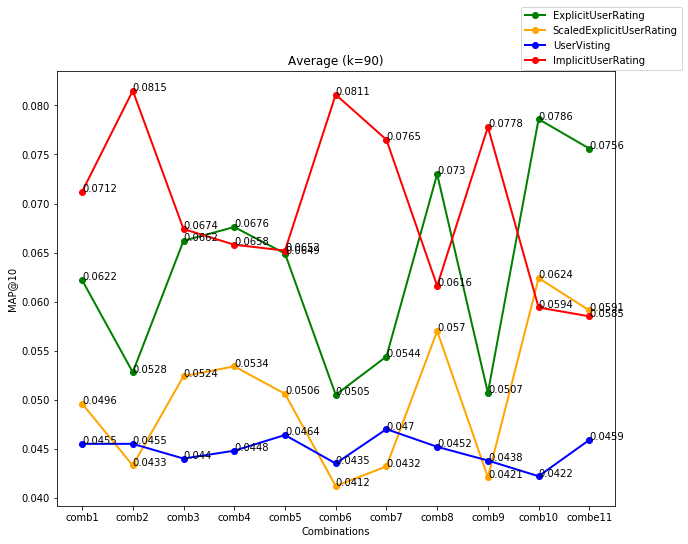

In [38]:
listPredictionAvg1 = predictionAvg1.items() # sorted by key, return a list of tuples
listPredictionAvg2 = predictionAvg2.items()
listPredictionAvg3 = predictionAvg3.items()
listPredictionAvg4 = predictionAvg4.items()

x1, y1 = zip(*listPredictionAvg1) # unpack a list of pairs into two tuples
x2, y2 = zip(*listPredictionAvg2)
x3, y3 = zip(*listPredictionAvg3)
x4, y4 = zip(*listPredictionAvg4)

plt.figure(figsize=(10,8))
plt.plot( x1, y1, marker='o',color='green', linewidth=2, label="ExplicitUserRating")
plt.plot( x2, y2, marker='o',color='orange', linewidth=2, label="ScaledExplicitUserRating")
plt.plot( x3, y3, marker='o',color='blue', linewidth=2, label="UserVisting")
plt.plot( x4, y4, marker='o',color='red', linewidth=2, label="ImplicitUserRating")

for x, y in zip(x1, y1): 
    plt.text(x, y, str(y))
for x, y in zip(x2, y2): 
    plt.text(x, y, str(y))
for x, y in zip(x3, y3): 
    plt.text(x, y, str(y))
for x, y in zip(x4, y4): 
    plt.text(x, y, str(y))
      
plt.title('Average (k=90)')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.xlabel('Combinations')
plt.ylabel('MAP@10')
plt.show()

In [ ]:
# def getImplicitMatrix(sparseMatrix, threashold=0):
#     temp_matrix = sparse.csr_matrix(sparseMatrix.shape)
#     temp_matrix[(sparseMatrix > threashold).nonzero()] = 1
#     return temp_matrix

# userVisitMatrix = getImplicitMatrix(rtrain)

In [ ]:
#UU similarity
similarity3 = train(userVisitMatrix)
#get a user-item matrix  UI prediction
#Predict using UI matrix with ratings in it 
user_item_prediction_score3 = predict(userVisitMatrix, 90, similarity3, item_similarity_en= False)
user_item_predict3 = prediction(user_item_prediction_score3, 50, userVisitMatrix)
#Check user item prediction score
user_item_res3 = evaluate(user_item_predict3, rvalid)

In [ ]:
user_item_res3